<a href="https://colab.research.google.com/github/squoraishee/BLSNet/blob/main/Smart_Targeting_Playbook_RCT_to_Revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **From RCT to Targeting: A Smart Targeting Playbook**

**Goal:** Use "messy" A/B data to build a policy that gives the right product to the right user.

---

## **0. The Scenario: The Gaming Arcade**

We ran an experiment (RCT) where we showed users one of two products:

* **Action 0:** *Animal Crossing* (A "Cozy" game)
* **Action 1:** *Candy Crush* (A "Puzzle" game)

We want to move past "Which game is better on average?" and find out "Which game is best for **this** specific user?"

---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## **1. Generate mock data**


In [ ]:
def generate_gaming_data(n=3000):
    """
    Generate synthetic gaming RCT data with configurable user behavior patterns.

    EXPERIMENT GUIDE:
    Change any parameter below to explore how different user behaviors affect targeting lift.
    Try varying preference strengths, sample sizes, or demographic distributions to see
    how robust your targeting policy is to different market conditions.
    """

    # ============================================================================
    # RANDOM SEED: Controls reproducibility
    # Set to None for different data each run, or use any integer for reproducibility
    # ============================================================================
    RANDOM_SEED = 42

    # ============================================================================
    # SAMPLE SIZE
    # ============================================================================
    SAMPLE_SIZE = n  # Total number of users in the RCT
    # TRY: 1000 (small sample, noisier results), 10000 (larger sample, clearer signals)

    # ============================================================================
    # USER DEMOGRAPHIC: AGE DISTRIBUTION
    # ============================================================================
    AGE_MEAN = 30           # Average user age
    AGE_STD = 10            # Standard deviation of ages
    AGE_MIN = 10            # Minimum plausible age
    AGE_MAX = 80            # Maximum plausible age
    # TRY: More realistic distributions like AGE_MEAN=28, AGE_STD=8 or AGE_MEAN=35, AGE_STD=12

    # ============================================================================
    # USER DEMOGRAPHIC: PLATFORM DISTRIBUTION
    # Platform distribution (equal split means 33% each)
    # ============================================================================
    PLATFORM_CHOICES = ['Mobile', 'Console', 'PC']
    PLATFORM_PROBS = [0.5, 0.3, 0.2]  # Skewed toward Mobile
    # TRY: [0.33, 0.33, 0.33] for equal distribution, or [0.7, 0.2, 0.1] for Mobile-dominant

    # ============================================================================
    # USER BEHAVIOR: SESSION DURATION (in minutes)
    # ============================================================================
    SESSION_MEAN = 45       # Average session length
    SESSION_STD = 20        # Variability in session lengths
    SESSION_MIN = 5         # Minimum session (quick play sessions)
    SESSION_MAX = 300       # Maximum session (marathon sessions)
    SESSION_SHORT_THRESHOLD = 30  # What counts as a "short" session?
    # TRY: Adjust SESSION_MEAN up to 60+ to simulate more engaged users, or down to 25
    # TRY: Adjust SESSION_SHORT_THRESHOLD to 20 or 40 to change who qualifies as "short session"

    # ============================================================================
    # USER PROFILE: SUBSCRIPTION STATUS
    # ============================================================================
    SUBSCRIBER_PROB = 0.3   # What fraction of users are premium subscribers?
    # TRY: 0.1 (mostly free users), 0.5 (half/half), or 0.8 (mostly premium)

    # ============================================================================
    # RCT TREATMENT ASSIGNMENT
    # ============================================================================
    PROB_ACTION_1 = 0.55    # Probability user sees Action 1 (Candy Crush) in RCT
    # If 0.55, then 55% see Candy Crush, 45% see Animal Crossing
    # TRY: 0.5 (perfectly balanced), 0.7 (heavily skewed), or 0.3 (opposite skew)
    # NOTE: More imbalance = harder for Hajek estimator, more targeting opportunity

    # ============================================================================
    # SUCCESS SIGNAL STRENGTH: Heterogeneous Treatment Effects
    # These control HOW MUCH each user segment prefers each game
    # ============================================================================

    # Coefficient for: "Mobile users with SHORT sessions love Candy Crush (Action 1)"
    MOBILE_SHORT_ACTION1_COEF = 3.0
    # TRY: 1.0 (weak preference), 5.0 (strong preference), 0.0 (no preference at all)

    # Coefficient for: "Console users love Animal Crossing (Action 0)"
    CONSOLE_ACTION0_COEF = 3.0
    # TRY: 2.0 (moderate preference), 5.0 (strong preference), 0.0 (no preference)

    # Baseline difficulty: how hard is it to get ANY conversion?
    # Negative = harder to convert, positive = easier to convert
    BASELINE_DIFFICULTY = -2.0
    # TRY: 0.0 (neutral), -3.0 (very hard to convert), 1.0 (easy to convert)
    # Higher baseline difficulty = lower overall engagement, but clearer targeting signal

    # ============================================================================
    # NOW RUN THE SIMULATION
    # ============================================================================

    np.random.seed(RANDOM_SEED)

    # Generate user demographics
    age = np.random.normal(AGE_MEAN, AGE_STD, SAMPLE_SIZE).clip(AGE_MIN, AGE_MAX)
    platform = np.random.choice(PLATFORM_CHOICES, SAMPLE_SIZE, p=PLATFORM_PROBS)
    session_min = np.random.normal(SESSION_MEAN, SESSION_STD, SAMPLE_SIZE).clip(SESSION_MIN, SESSION_MAX)
    is_subscriber = np.random.binomial(1, SUBSCRIBER_PROB, SAMPLE_SIZE)

    # Simulate RCT treatment assignment
    action = np.random.binomial(1, PROB_ACTION_1, SAMPLE_SIZE)

    # Define success probability based on user type × assigned game
    # This encodes the "ground truth" heterogeneous treatment effects
    logit = (
        MOBILE_SHORT_ACTION1_COEF * (platform == 'Mobile') * (session_min < SESSION_SHORT_THRESHOLD) * (action == 1) +
        CONSOLE_ACTION0_COEF * (platform == 'Console') * (action == 0) +
        BASELINE_DIFFICULTY
    )

    # Convert logit to probability and generate outcomes
    prob = 1 / (1 + np.exp(-logit))
    y = np.random.binomial(1, prob)

    return pd.DataFrame({
        'age': age, 'platform': platform, 'session': session_min,
        'subscriber': is_subscriber, 'action': action, 'y': y
    })


In [ ]:
df = generate_gaming_data()
print(f"Data Loaded: {len(df)} users.")
print(f"RCT Split: {df.action.mean():.1%} saw Candy Crush.")
df.head()

Data Loaded: 3000 users.
RCT Split: 55.2% saw Candy Crush.


,age,platform,session,subscriber,action,y
0,34.967142,PC,41.195183,0,1,0
1,28.617357,PC,15.051067,1,0,1
2,36.476885,Mobile,72.264580,1,1,0
3,45.230299,PC,38.927479,1,1,0
4,27.658466,Mobile,35.222278,0,0,0


---

## **2. Phase 1: ML/Training the "Brain"**

We learn a model (here using `LogisticRegression`) to act as our **Value Function ()**. It learns to predict the probability of a user playing the game based on their traits **and** the action we took.

---

In [ ]:
# Create interaction features to capture heterogeneous treatment effects
def add_interactions(X):
    X_copy = X.copy()
    X_copy['mobile_short_session'] = ((X['platform'] == 'Mobile') & (X['session'] < 30)).astype(int)
    X_copy['action_mobile_short'] = X_copy['mobile_short_session'] * X['action']
    X_copy['action_console'] = (X['platform'] == 'Console').astype(int) * X['action']
    return X_copy


In [ ]:
# Create a pipeline to handle mixed data (Numbers, Categories, Booleans)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['age', 'session']),
    ('cat', OneHotEncoder(), ['platform']),
    ('bool', 'passthrough', ['subscriber', 'action', 'mobile_short_session', 'action_mobile_short', 'action_console'])
])

# Use Logistic Regression to minimize "Distance" (Log-Loss)
model = Pipeline([
    ('interactions', FunctionTransformer(add_interactions, validate=False)),
    ('prep', preprocessor),
    ('clf', LogisticRegression())
])

model.fit(df.drop('y', axis=1), df['y'])
print("Model trained: The 'Brain' now understands player preferences.")

Model trained: The 'Brain' now understands player preferences.


---

## **3. Phase 2: Building the Policy & Estimating lift**

Now we define our **Policy ()**:

> *"For every user, simulate showing them BOTH games. Pick the one the model says has a higher win chance."*

**The Challenge:** Since we only have RCT data, we use averages only over people who saw in the RCT what the new model thinks they *should* have seen. It also adjusts the averages to account for the fact that our original test wasn't a perfect 50/50 split (technical term : "Hajek Estimator"). This ensures our "Targeting" numbers are honest.

---

In [ ]:
def run_evaluation(data, iterations=500):
    all_results = []

    for _ in range(iterations):
        # Bootstrap: Shuffle and sample the data to get error bars
        s = data.sample(frac=1.0, replace=True)

        # 1. Empirical 'Pi' (The actual RCT split in this sample)
        pi_1 = s['action'].mean()
        pi_0 = 1 - pi_1

        # 2. Determine Policy Choice (h)
        # We ask: "What if we gave them A0? What if we gave them A1?"
        d0 = s.copy(); d0['action'] = 0
        d1 = s.copy(); d1['action'] = 1
        p0 = model.predict_proba(d0.drop('y', axis=1))[:, 1]
        p1 = model.predict_proba(d1.drop('y', axis=1))[:, 1]
        h = (p1 > p0).astype(int)

        # 3. Calculate Hajek Score for Targeted Policy
        # Only look at users where our Policy matched what actually happened in the RCT
        matches = (s['action'] == h)
        weights = np.where(s['action'] == 1, 1/pi_1, 1/pi_0)



        # Hajek = Weighted Sum / Sum of Weights
        hajek_score = (s['y'][matches] * weights[matches]).sum() / weights[matches].sum()

        # 4. Compare to Baselines (Always Action 0 or Always Action 1)
        score_a0 = s[s['action'] == 0]['y'].mean()
        score_a1 = s[s['action'] == 1]['y'].mean()

        all_results.append([hajek_score, score_a1, score_a0])

    return pd.DataFrame(all_results, columns=['Smart Targeting', 'Always Candy Crush', 'Always Animal Crossing'])

results = run_evaluation(df)

---

## **4. The Results: Targeting vs. One-size-fits-all vs. Random**

We want to see the **Smart Targeting** bar significantly higher than the others. We've added error bars to show the 95% confidence interval.

---

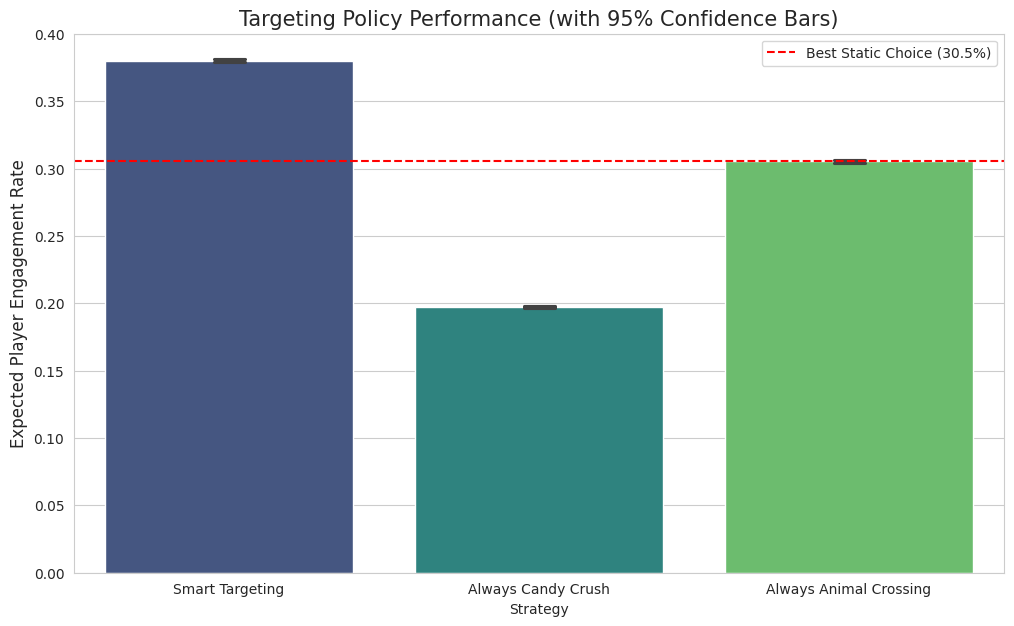

CONCLUSION: Our Targeting Policy provides a 24.4% performance lift over the best static option.


In [ ]:
# Plotting
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Melt data for plotting
melted = results.melt(var_name='Strategy', value_name='Win Rate')
ax = sns.barplot(x='Strategy', y='Win Rate', data=melted, hue='Strategy', palette="viridis", errorbar=('ci', 95), capsize=.1, legend = False)

# Add a "Baseline" line (the best a non-personalized approach could do)
best_static = max(results['Always Candy Crush'].mean(), results['Always Animal Crossing'].mean())
plt.axhline(best_static, color='red', linestyle='--', label=f'Best Static Choice ({best_static:.1%})')

plt.title("Targeting Policy Performance (with 95% Confidence Bars)", fontsize=15)
plt.ylabel("Expected Player Engagement Rate", fontsize=12)
plt.legend()
plt.show()

lift = (results['Smart Targeting'].mean() - best_static) / best_static
print(f"CONCLUSION: Our Targeting Policy provides a {lift:.1%} performance lift over the best static option.")